This is some interesting maths...

$\sum{}_{i=1}^{n} i = \frac{n(n+1)}{2}$

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from import_OMNI import read_OMNI
from entropy import H, MI, CMI

%matplotlib inline

In [3]:
df, columns = read_OMNI(
    filepath="../datasets/test_AE_SYM_ASY_all.txt",
    formatpath="../data_format/test_AE_SYM_ASY_all_format.txt",
    return_columns=True
)
print(columns)


c:\Users\Aarnav\Downloads\UROP2024\UROP2024\src\import_OMNI.py:39: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(


['Datetime', 'Field', 'BZ', 'AE-index', 'SYM/D', 'SYM/H', 'ASY/D', 'ASY/H']


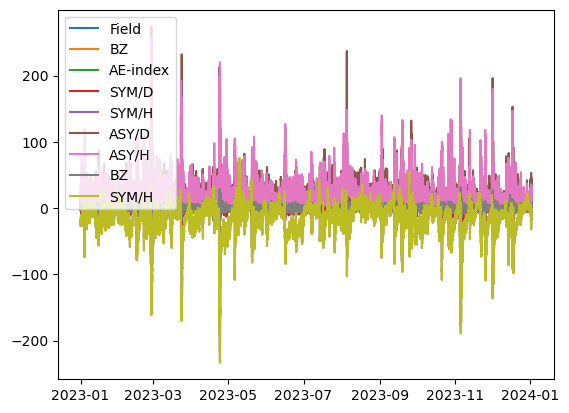

In [4]:
for column in columns[1:]:
    plt.plot(df["Datetime"], df[column], label=column)
plt.plot(df["Datetime"], df["BZ"], label="BZ")
plt.plot(df["Datetime"], df["SYM/H"], label="SYM/H")
# plt.hist(df["SYM/H"], 150)
plt.legend()
plt.show()

In [5]:
print(H(df["BZ"].to_numpy(), bins= 50))
print(H(df["BZ"].to_numpy(), df["SYM/H"].to_numpy(), bins= 50))

3.463418112675315
(array([-21., -21., -21., ...,  -4.,  -4.,  -4.]),)
<class 'numpy.ndarray'> <class 'tuple'>


TypeError: 'tuple' object is not callable